In [1]:
!pip install rdkit
!pip install torch_geometric
!pip install lightning -U
!pip install wandb -U

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.9/34.9 MB 48.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.2/64.2 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 26.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.4/53.4 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 37.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.7/6.7 MB 58.5 MB/s eta 0:00:00
  Attempting uninstall: wandb
    Found existing installation: wandb 0.16.6
    Uninstalling wandb-0.16.6:
      Successfully uninstalled wandb-0.16.6


In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
import lightning as L
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
from pathlib import Path
from scipy.stats import pearsonr
import sklearn.metrics as skmetrics
import seaborn as sns
import matplotlib.pyplot as plt
import lightning as L
import torch.nn as nn
import torch.optim as optim
from lightning import seed_everything
from lightning.pytorch.callbacks import ModelCheckpoint, BaseFinetuning, EarlyStopping, LambdaCallback
from lightning.pytorch.loggers import WandbLogger
import wandb

from torch_geometric.loader import DataLoader

import os
#for dirname, _, filenames in os.walk('../input'):
#    for filename in filenames[:5]:
#        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Common

In [ ]:
try:
    from kaggle_secrets import UserSecretsClient
    wandb_api = UserSecretsClient().get_secret("wandb_key") 
except Exception as e:
    print(e)
    wandb_api = None
if wandb_api is not None:
    wandb.login(key=wandb_api)

In [3]:
DRAFT_MODE = False

BATCH_SIZE = 512 # 1024
target_names = ["pIC50", "pKi"]

DATADIR = Path("../Reference Data")
if not DATADIR.exists():
    # this is the path with the data which was used during kaggle notebook run
    DATADIR = "../input/cache-data-split"

In [4]:
import random
import torch
import os
import sys


def set_seed(seed: int = 42) -> None:
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    # When running on the CuDNN backend, two further options must be set
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    # Set a fixed value for the hash seed
    os.environ["PYTHONHASHSEED"] = str(seed)
    print(f"Random seed set as {seed}")
    
RANDOM_STATE=2407
set_seed(RANDOM_STATE)

Random seed set as 2407


# Data

In [5]:
import pandas as pd
from pathlib import Path
import torch
import numpy as np
from torch_geometric.data import Data, InMemoryDataset
from rdkit import Chem

from rdkit.Chem.rdchem import BondType as BT
from rdkit import Chem


ATOM_LIST = list(range(1,119))
CHIRALITY_LIST = [
    Chem.rdchem.ChiralType.CHI_UNSPECIFIED,
    Chem.rdchem.ChiralType.CHI_TETRAHEDRAL_CW,
    Chem.rdchem.ChiralType.CHI_TETRAHEDRAL_CCW,
    Chem.rdchem.ChiralType.CHI_OTHER
]
BOND_LIST = [BT.SINGLE, BT.DOUBLE, BT.TRIPLE, BT.AROMATIC]
BONDDIR_LIST = [
    Chem.rdchem.BondDir.NONE,
    Chem.rdchem.BondDir.ENDUPRIGHT,
    Chem.rdchem.BondDir.ENDDOWNRIGHT
]


def smiles2pyg_data(smiles, regression_target=None, classification_target=None, **kwargs):
    mol = Chem.MolFromSmiles(smiles)
    mol = Chem.AddHs(mol)

    num_atoms = mol.GetNumAtoms()
    num_bonds = mol.GetNumBonds()

    type_idx = []
    chirality_idx = []
    atomic_number = []
    for atom in mol.GetAtoms():
        type_idx.append(ATOM_LIST.index(atom.GetAtomicNum()))
        chirality_idx.append(CHIRALITY_LIST.index(atom.GetChiralTag()))
        atomic_number.append(atom.GetAtomicNum())

    x1 = torch.tensor(type_idx, dtype=torch.long).view(-1,1)
    x2 = torch.tensor(chirality_idx, dtype=torch.long).view(-1,1)
    x = torch.cat([x1, x2], dim=-1)

    row, col, edge_feat = [], [], []
    for bond in mol.GetBonds():
        start, end = bond.GetBeginAtomIdx(), bond.GetEndAtomIdx()
        row += [start, end]
        col += [end, start]
        edge_feat.append([
            BOND_LIST.index(bond.GetBondType()),
            BONDDIR_LIST.index(bond.GetBondDir())
        ])
        edge_feat.append([
            BOND_LIST.index(bond.GetBondType()),
            BONDDIR_LIST.index(bond.GetBondDir())
        ])

    edge_index = torch.tensor([row, col], dtype=torch.long)
    edge_attr = torch.tensor(np.array(edge_feat), dtype=torch.long)
    # if target is None:
    #     return Data(x=x, edge_index=edge_index, edge_attr=edge_attr, **kwargs)
    #if task == 'classification':
    #    y = torch.tensor(target, dtype=torch.long).view(1,-1)
    #elif task == 'regression':
    #    y = torch.tensor(target, dtype=torch.float).view(1,-1)
    if regression_target is not None:
        regression_target = torch.tensor(regression_target, dtype=torch.float).view(1,-1)
        kwargs['regression_target'] = regression_target
    if classification_target is not None:
        classification_target = torch.tensor(classification_target, dtype=torch.long)  #.view(1,-1)
        kwargs['classification_target'] = classification_target

    data = Data(x=x, edge_index=edge_index, edge_attr=edge_attr, **kwargs)
    return data


class CacheDataset(InMemoryDataset):
    def __init__(self, df, inference_mode=False, additional_columns=[], root="temp_cache", transform=None, pre_transform=None, pre_filter=None):
        assert isinstance(df, pd.DataFrame)

        super().__init__(root, transform, pre_transform, pre_filter)
        self.df = df
        self.inference_mode = inference_mode
        self.additional_columns = [
            column for column in additional_columns if column in df.columns
        ]

        self.data_index = np.asarray(df.index)
        self.smiles_column = "smiles"
        self.regression_column = "acvalue_uM"
        self.classification_column = "class"
        self.regression_name_column = "acname"
        
    @property
    def raw_file_names(self):
        return []
        # return [self.filename]

    @property
    def processed_file_names(self):
        return []
    def len(self):
        return len(self.data_index)

    def get(self, idx):
        index = self.data_index[idx]
        smiles = self.df.loc[index, self.smiles_column]
        kwargs = {}
        if len(self.additional_columns) > 0:
            for column in self.additional_columns:
                kwargs[column] = self.df.loc[index, column]
        if not self.inference_mode:
            regression_name = self.df.loc[index, self.regression_name_column]
            regression_value = self.df.loc[index, self.regression_column]
            classification_value = self.df.loc[index, self.classification_column]
            kwargs['regression_target'] = regression_value
            kwargs['classification_target'] = classification_value
            kwargs['regression_name'] = regression_name

        return smiles2pyg_data(smiles, **kwargs)

    def process(self):
        pass


In [6]:
train_folds = [f"Fold_{i}" for i in range(7)]
val_folds = ["Fold_7"]
test_folds = ["Fold_8"]

data_df = pd.read_csv(DATADIR / "20240430_MCHR1_splitted_RJ.csv")

train_df = data_df[data_df.DataSAIL_10f.isin(train_folds)]
val_df = data_df[data_df.DataSAIL_10f.isin(val_folds)]
test_df = data_df[data_df.DataSAIL_10f.isin(test_folds)]

train_datasets = {
    acname: CacheDataset(train_df[train_df.acname == acname]) 
    for acname in train_df.acname.unique()
}

# https://github.com/Lightning-AI/pytorch-lightning/discussions/12048
val_datasets = [
    CacheDataset(val_df[val_df.acname == acname]) 
    for acname in target_names
]

test_datasets = [
    CacheDataset(test_df[test_df.acname == acname]) 
    for acname in target_names
]

Processing...
Done!
Processing...
Done!
Processing...
Done!
Processing...
Done!
Processing...
Done!
Processing...
Done!


In [7]:

train_dataloaders = {
    acname: DataLoader(
        ds, batch_size=BATCH_SIZE, drop_last=True, shuffle=True,
        num_workers=3
    ) 
    for acname, ds in train_datasets.items()
}

# https://github.com/Lightning-AI/pytorch-lightning/discussions/12048
val_dataloaders = [
    DataLoader(ds, batch_size=BATCH_SIZE, num_workers=3) 
    for ds in val_datasets
]

test_dataloaders = [
    DataLoader(ds, batch_size=BATCH_SIZE, num_workers=3) 
    for ds in test_datasets
]

# Losses

In [8]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F


class FC(nn.Module):
    def __init__(self, d_graph_layer, fc_hidden_dim, dropout, n_tasks):
        super(FC, self).__init__()

        self.predict = nn.ModuleList()
        for index, dim in enumerate(fc_hidden_dim):
            self.predict.append(nn.Linear(d_graph_layer, dim))
            self.predict.append(nn.Dropout(dropout))
            self.predict.append(nn.LeakyReLU())
            self.predict.append(nn.BatchNorm1d(dim))
            d_graph_layer = dim
        self.predict.append(nn.Linear(d_graph_layer, n_tasks))

    def forward(self, h):
        for layer in self.predict:
            h = layer(h)
        # return torch.sigmoid(h)
        return h


class RankingLoss(nn.Module):
    def __init__(self, embedding_out_dim, dropout=0.3, ntasks=2):
        super(RankingLoss, self).__init__()
        #self.config = config
        self.loss_fn = nn.CrossEntropyLoss() # TODO: check this - was reduce=False #reduce=False)
        #if config.model.readout.startswith('multi_head') and config.model.attn_merge == 'concat':
        #    self.relation_mlp = FC(embedding_out_dim * (config.model.num_head + 1) * 2, 
        #    [embedding_out_dim * 2, embedding_out_dim], dropout, 2)
        #else:
        self.embedding_out_dim = embedding_out_dim
        self.relation_mlp = FC(
            embedding_out_dim * 2, 
            [embedding_out_dim, embedding_out_dim // 2], 
            dropout, 
            ntasks
        )
        self.m = nn.Softmax(dim=1)

    @torch.no_grad()
    def get_rank_relation(self, y_A, y_B):
        # y_A: [batch, 1]
        # target_relation: 0: <=, 1: >
        target_relation = torch.zeros(y_A.size(), dtype=torch.long, device=y_A.device)
        target_relation[(y_A - y_B) > 0.0] = 1

        return target_relation.squeeze()

    def forward(self, output_embedding, target):
        batch_repeat_num = len(output_embedding)
        # if batch_repeat_num // 2 < 1 and batch_repeat_num % 2 != 0:
        #     return None, None, None
        shift = max(batch_repeat_num // 2, 1)
        #batch_size = batch_repeat_num // 2
        #x_A, y_A, x_B, y_B = output_embedding[:batch_size], target[:batch_size],\
        #                     output_embedding[batch_size:], target[batch_size:]
        x_A, y_A = output_embedding, target
        x_B = torch.roll(output_embedding, shift, 0)
        y_B = torch.roll(target, shift, 0)

        relation = self.get_rank_relation(y_A, y_B)
        # print(x_A.shape, x_B.shape, y_A.shape, y_B.shape)
        relation_pred = self.relation_mlp(torch.cat([x_A, x_B], dim=1))

        ranking_loss = self.loss_fn(relation_pred, relation)

        _, y_pred = self.m(relation_pred).max(dim=1)

        return ranking_loss, relation.squeeze(), y_pred

# Model

## GINet

In [9]:
import torch
from torch import nn
import torch.nn.functional as F

from torch_geometric.nn import MessagePassing
from torch_geometric.utils import add_self_loops
from torch_geometric.nn import global_add_pool, global_mean_pool, global_max_pool

num_atom_type = 119 # including the extra mask tokens
num_chirality_tag = 3

num_bond_type = 5 # including aromatic and self-loop edge
num_bond_direction = 3 


class GINEConv(MessagePassing):
    def __init__(self, emb_dim):
        super(GINEConv, self).__init__()
        self.mlp = nn.Sequential(
            nn.Linear(emb_dim, 2*emb_dim), 
            nn.ReLU(), 
            nn.Linear(2*emb_dim, emb_dim)
        )
        self.edge_embedding1 = nn.Embedding(num_bond_type, emb_dim)
        self.edge_embedding2 = nn.Embedding(num_bond_direction, emb_dim)

        nn.init.xavier_uniform_(self.edge_embedding1.weight.data)
        nn.init.xavier_uniform_(self.edge_embedding2.weight.data)

    def forward(self, x, edge_index, edge_attr):
        # add self loops in the edge space
        edge_index = add_self_loops(edge_index, num_nodes=x.size(0))[0]

        # add features corresponding to self-loop edges.
        self_loop_attr = torch.zeros(x.size(0), 2)
        self_loop_attr[:,0] = 4 # bond type for self-loop edge
        self_loop_attr = self_loop_attr.to(edge_attr.device).to(edge_attr.dtype)
        edge_attr = torch.cat((edge_attr, self_loop_attr), dim=0)

        edge_embeddings = self.edge_embedding1(edge_attr[:,0]) + \
            self.edge_embedding2(edge_attr[:,1])

        return self.propagate(edge_index, x=x, edge_attr=edge_embeddings)

    def message(self, x_j, edge_attr):
        return x_j + edge_attr

    def update(self, aggr_out):
        return self.mlp(aggr_out)


class GINet(nn.Module):
    """
    Args:
        num_layer (int): the number of GNN layers
        emb_dim (int): dimensionality of embeddings
        drop_ratio (float): dropout rate
        gnn_type: gin, gcn, graphsage, gat
    Output:
        node representations
    """
    def __init__(self, 
        task='classification', num_layer=5, emb_dim=300, feat_dim=512, 
        drop_ratio=0, pool='mean', pred_n_layer=2, pred_act='softplus'
    ):
        super(GINet, self).__init__()
        self.num_layer = num_layer
        self.emb_dim = emb_dim
        self.feat_dim = feat_dim
        self.drop_ratio = drop_ratio
        self.task = task

        self.x_embedding1 = nn.Embedding(num_atom_type, emb_dim)
        self.x_embedding2 = nn.Embedding(num_chirality_tag, emb_dim)
        nn.init.xavier_uniform_(self.x_embedding1.weight.data)
        nn.init.xavier_uniform_(self.x_embedding2.weight.data)

        # List of MLPs
        self.gnns = nn.ModuleList()
        for layer in range(num_layer):
            self.gnns.append(GINEConv(emb_dim))

        # List of batchnorms
        self.batch_norms = nn.ModuleList()
        for layer in range(num_layer):
            self.batch_norms.append(nn.BatchNorm1d(emb_dim))

        if pool == 'mean':
            self.pool = global_mean_pool
        elif pool == 'max':
            self.pool = global_max_pool
        elif pool == 'add':
            self.pool = global_add_pool
        self.feat_lin = nn.Linear(self.emb_dim, self.feat_dim)

        if self.task == 'classification':
            out_dim = 2
        elif self.task == 'regression':
            out_dim = 1
        if self.task != "head":
            self.pred_n_layer = max(1, pred_n_layer)

            if pred_act == 'relu':
                pred_head = [
                    nn.Linear(self.feat_dim, self.feat_dim//2), 
                    nn.ReLU(inplace=True)
                ]
                for _ in range(self.pred_n_layer - 1):
                    pred_head.extend([
                        nn.Linear(self.feat_dim//2, self.feat_dim//2), 
                        nn.ReLU(inplace=True),
                    ])
                pred_head.append(nn.Linear(self.feat_dim//2, out_dim))
            elif pred_act == 'softplus':
                pred_head = [
                    nn.Linear(self.feat_dim, self.feat_dim//2), 
                    nn.Softplus()
                ]
                for _ in range(self.pred_n_layer - 1):
                    pred_head.extend([
                        nn.Linear(self.feat_dim//2, self.feat_dim//2), 
                        nn.Softplus()
                    ])
            else:
                raise ValueError('Undefined activation function')

            pred_head.append(nn.Linear(self.feat_dim//2, out_dim))
            self.pred_head = nn.Sequential(*pred_head)

    def forward(self, data):
        x = data.x
        edge_index = data.edge_index
        edge_attr = data.edge_attr
        
        h = self.x_embedding1(x[:,0]) + self.x_embedding2(x[:,1])

        for layer in range(self.num_layer):
            h = self.gnns[layer](h, edge_index, edge_attr)
            h = self.batch_norms[layer](h)
            if layer == self.num_layer - 1:
                h = F.dropout(h, self.drop_ratio, training=self.training)
            else:
                h = F.dropout(F.relu(h), self.drop_ratio, training=self.training)

        h = self.pool(h, data.batch)
        h = self.feat_lin(h)
        if self.task == "head":
            return h
        return h, self.pred_head(h)

    def load_my_state_dict(self, state_dict):
        own_state = self.state_dict()
        for name, param in state_dict.items():
            if name not in own_state:
                continue
            if isinstance(param, nn.parameter.Parameter):
                # backwards compatibility for serialized parameters
                param = param.data
            own_state[name].copy_(param)


## Common model-related

In [10]:
def _load_pre_trained_weights(model, ckpt_path="molclr_ckpt", device='cpu'):
    try:
        fine_tune_from = 'pretrained_gin'
        checkpoints_folder = os.path.join(ckpt_path, fine_tune_from, 'checkpoints')
        state_dict = torch.load(os.path.join(checkpoints_folder, 'model.pth'), map_location=device)
        # model.load_state_dict(state_dict)
        model.load_my_state_dict(state_dict)
        print("Loaded pre-trained model with success.")
    except FileNotFoundError:
        print("Pre-trained weights not found. Training from scratch.")

    return model

In [11]:
model_params = dict(
    num_layer=5,  # number of graph conv layers
    emb_dim=300,  # embedding dimension in graph conv layers
    feat_dim=512,  # output feature dimention
    drop_ratio= 0.3,  # dropout ratio
    pool= 'mean'  # readout pooling (i.e., mean/max/add)
)

# Model wrapper

In [12]:
from collections import defaultdict
# import sklearn.metrics as skmetrics


class MolCLRWrapper(L.LightningModule):
    def __init__(self, target_names=["pIC50", "pKi"], ckpt_path=None, device='cpu', dropout=0.3):
        super().__init__()
        # self.device = device
        self.target_names = target_names
        self.feature_dim = model_params['feat_dim']
        self.dropout = model_params['drop_ratio']
        self.head = GINet('head', **model_params)  #.to(self.device)
#         self.regression_heads = {
#             name: FC(self.feature_dim, [self.feature_dim // 2, self.feature_dim // 4], dropout, 1)
#             for name in task_names
#         }
        if not ckpt_path is None:
            self.head = _load_pre_trained_weights(self.head, ckpt_path=ckpt_path)

        self.ranking_losses_func = nn.ModuleDict({
            name: RankingLoss(model_params['feat_dim'])
            for name in target_names
        })

        self.regression_heads = nn.ModuleDict({
            name: FC(
                self.feature_dim, [self.feature_dim // 2, self.feature_dim // 4], 
                self.dropout, 1
            )
            for name in target_names
        })
        self.classification_head = FC(
            self.feature_dim, [self.feature_dim // 2, self.feature_dim // 4], 
            self.dropout, 2
        )
        # 
        self.validation_loss_outputs = defaultdict(list)

        self.validation_regression_outputs = defaultdict(list)
        self.validation_regression_gt = defaultdict(list)
        self.validation_classification_outputs = defaultdict(list)
        self.validation_classification_gt = defaultdict(list)
        
        self.test_regression_outputs = defaultdict(list)
        self.test_regression_gt = defaultdict(list)
        self.test_classification_outputs = []  # defaultdict(list)
        self.test_classification_gt = []  # defaultdict(list)
        
        self.ranking_lambda = 1.
        self.classification_lambda = 1.0
        self.regression_lambda = 0.5
    
    def training_step(self, batch, batch_idx, dataloader_idx=0):
        if not isinstance(batch, dict):
            raise "Not implemented"
        regression_losses = []
        ranking_losses = []
        classification_losses = []

        for k, v in batch.items():
            batch_embeddings = self.head(v)
            ranking_loss, relation, y_pred = self.ranking_losses_func[k](batch_embeddings, v.regression_target)
            if ranking_loss is not None:
                ranking_losses.append(ranking_loss)

            reg_predictions = self.regression_heads[k](batch_embeddings)
            reg_loss = F.mse_loss(reg_predictions, v.regression_target)
            regression_losses.append(reg_loss)

            classification_logits = self.classification_head(batch_embeddings)
            classification_loss = F.cross_entropy(classification_logits, v.classification_target)
            classification_losses.append(classification_loss)

        ranking_loss = torch.sum(torch.stack(ranking_losses))
        regression_loss = torch.sum(torch.stack(regression_losses))
        classification_loss = torch.sum(torch.stack(classification_losses))            
        loss = self.ranking_lambda * ranking_loss + self.regression_lambda * regression_loss + self.classification_lambda * classification_loss
        #if self.current_epoch > 250:
        #    loss = classification_loss
        self.log("train_loss", loss, sync_dist=True)
        return loss

    def forward(self, data_batch):
        batch_embeddings, regression_predictions, classification_logits, class_probabilities = self._get_embeddings_and_predictions(data_batch)
        return regression_predictions, class_probabilities
    
    def _get_embeddings_and_predictions(self, data_batch):
        regression_predictions = dict()
        batch_embeddings = self.head(data_batch)
        # print(batch_embeddings.shape)
        regression_predictions = {
            k: self.regression_heads[k](batch_embeddings)
            for k in self.regression_heads
        }

        classification_logits = self.classification_head(batch_embeddings)
        # print(classification_logits.shape) # [batch_size, 2]
        class_probabilities = F.softmax(classification_logits, dim=1)
        return batch_embeddings, regression_predictions, classification_logits, class_probabilities
    
    def validation_step(self, batch, batch_idx, dataloader_idx=0):
        # TODO: add metrics for classification and regression
        batch_embeddings, regression_predictions, classification_logits, class_probabilities = self._get_embeddings_and_predictions(batch)
        classification_loss = F.cross_entropy(classification_logits, batch.classification_target)
        
        target = target_names[dataloader_idx]
        ranking_loss, relation, y_pred = self.ranking_losses_func[target](batch_embeddings, batch.regression_target)
        # ranking_losses.append(ranking_loss)
        # reg_predictions = self.regression_heads[k](batch_embeddings)
        
        regression_loss = F.mse_loss(regression_predictions[target], batch.regression_target)
        # val_loss = classification_loss # + regression_loss 
        val_loss = self.ranking_lambda * ranking_loss + self.regression_lambda * regression_loss + self.classification_lambda * classification_loss
        scores = {
            'val_loss': val_loss,
            'classification_loss': classification_loss,
            'regression_loss': regression_loss,
        }
        #if ranking_loss is not None:
        #    val_loss += ranking_loss
        #    scores['ranking_loss'] = ranking_loss
        #scores['val_loss'] = val_loss

        self.validation_loss_outputs[dataloader_idx].append(val_loss)
        # save regression info
        self.validation_regression_outputs[dataloader_idx].append(regression_predictions[target].detach().cpu())
        self.validation_regression_gt[dataloader_idx].append(batch.regression_target.detach().cpu())
        # save classification info
        self.validation_classification_outputs[dataloader_idx].append(class_probabilities.detach().cpu())
        self.validation_classification_gt[dataloader_idx].append(batch.classification_target.detach().cpu())
        # log scores and return
        self.log_dict(scores)
        return val_loss
    
    def on_validation_epoch_end(self):
        # all_preds = torch.stack(self.validation_step_outputs)
        val_losses = []
        for dataloader_idx in self.validation_loss_outputs:
            val_losses.extend(self.validation_loss_outputs[dataloader_idx])
            self.validation_loss_outputs[dataloader_idx].clear()  # free memory
        val_losses = torch.stack(val_losses)
        scores = {
            "val_loss": val_losses.sum()
        }
        # aggregate regression predictions and gt values and compute validation metrics
        for dataloader_idx in self.validation_regression_outputs:
            # print(self.validation_regression_outputs, dataloader_idx)
            outputs = torch.concatenate(self.validation_regression_outputs[dataloader_idx], axis=0).squeeze()
            gts = torch.concatenate(self.validation_regression_gt[dataloader_idx], axis=0).squeeze()
            scores[f"reg_MAE_{dataloader_idx}"] = skmetrics.mean_absolute_error(gts, outputs)
            scores[f"reg_MSE_{dataloader_idx}"] = skmetrics.mean_squared_error(gts, outputs)
            scores[f"reg_R2_{dataloader_idx}"] = skmetrics.r2_score(gts, outputs)
            
            self.validation_regression_outputs[dataloader_idx].clear()
            self.validation_regression_gt[dataloader_idx].clear()
            # print(dataloader_idx, outputs.shape, gts.shape)
        # aggregate class predictions and gt values and compute validation metrics
        for dataloader_idx in self.validation_classification_outputs:
            # print(self.validation_classification_gt)
            outputs = torch.concatenate(self.validation_classification_outputs[dataloader_idx], axis=0)[:, 1]
            gts = torch.concatenate(self.validation_classification_gt[dataloader_idx], axis=0)
            try:
                scores[f'classif_roc_auc_{dataloader_idx}'] = skmetrics.roc_auc_score(gts, outputs)
                scores[f'classif_accuracy_{dataloader_idx}'] = skmetrics.accuracy_score(gts, outputs > 0.5)
                scores[f'classif_f1_{dataloader_idx}'] = skmetrics.f1_score(gts, outputs > 0.5)
            except:
                continue
            # print(outputs.shape, gts.shape)
            self.validation_classification_outputs[dataloader_idx].clear()
            self.validation_classification_gt[dataloader_idx].clear()
        self.log_dict(scores)
    
    def test_step(self, batch, batch_idx, dataloader_idx=0):
        regression_predictions, class_probabilities = self(batch)
        # print(regression_predictions)
        regression_predictions = {
            k: v.detach().cpu().numpy() 
            for k, v in regression_predictions.items()
        }
        class_probabilities = class_probabilities.detach().cpu().numpy()
        # loss = self.loss_fn(batch_predictions, batch.y)
        # labels_hat = torch.argmax(class_probabilities, dim=1).detach().cpu()  # .numpy()
        # logits = batch_predictions.detach().cpu().numpy()
        # probabilities = F.softmax(batch_predictions, dim=1)
        # probabilities = probabilities.detach().cpu().numpy()
        regression_gt = batch.regression_target.detach().cpu().numpy()
        regression_name = batch.regression_name
        #print(regression_name)
        #print(regression_gt.shape)
        target_name = target_names[dataloader_idx]
        for name in self.target_names:
            preds = regression_predictions[name]
            self.test_regression_outputs[name].append(preds)
            self.test_regression_gt[name].append(regression_gt)
            # print(name, preds.shape, regression_gt.shape)
        
        classification_gt = batch.classification_target.detach().cpu().numpy()
        self.test_classification_outputs.append(class_probabilities)
        self.test_classification_gt.append(classification_gt)
        
    def on_test_epoch_end(self):
        data = []
        scores = {}
        for target_name in target_names:    
            pred_values = np.concatenate(self.test_regression_outputs[target_name]).flatten()
            # labels_hat = np.argmax(probabilities, axis=1)
            gt_values = np.concatenate(self.test_regression_gt[target_name]).flatten()
            # print(pred_values.shape, gt_values.shape)
            p = pearsonr(pred_values, gt_values)
            scores[f'pearson_{target_name}_pvalue'] = p.pvalue
            scores[f'pearson_{target_name}_stat'] = p.statistic
            #scores[f'test_accuracy'] = skmetrics.accuracy_score(y_true, labels_hat)
            #scores[f'test_f1'] = skmetrics.f1_score(y_true, labels_hat)
            #test_auc = skmetrics.roc_auc_score(y_true, probabilities[:, 1])
            #scores[f'test_auc'] = test_auc

            data = [[x, y] for (x, y) in zip(pred_values, gt_values)]
            table = wandb.Table(data=data, columns = ["predictions", "true_values"])
            wandb.log({
                f"scatter_{target_name}": wandb.plot.scatter(
                    table, "predictions", "true_values", title="Predicted vs. GT values")
            })
            scores[f"test_reg_MAE_{target_name}"] = skmetrics.mean_absolute_error(gt_values, pred_values)
            scores[f"test_reg_MSE_{target_name}"] = skmetrics.mean_squared_error(gt_values, pred_values)
            scores[f"test_reg_R2_{target_name}"] = skmetrics.r2_score(gt_values, pred_values)
            self.test_regression_outputs[target_name].clear()
            self.test_regression_gt[target_name].clear()

        pred_values = np.concatenate(self.test_classification_outputs)
        gt_values = np.concatenate(self.test_classification_gt)
        labels_hat = np.argmax(pred_values, axis=1)
        
        scores[f'test_accuracy'] = skmetrics.accuracy_score(gt_values, labels_hat)
        scores[f'test_f1'] = skmetrics.f1_score(gt_values, labels_hat)
        test_auc = skmetrics.roc_auc_score(gt_values, pred_values[:, 1])
        scores[f'test_auc'] = test_auc
        # print(gt_values.shape, pred_values[:, 1].shape)
        # print(gt_values[:5], pred_values[:5, 1])

        wandb.log({
            f"test_roc" : wandb.plot.roc_curve(
                gt_values, pred_values,
                title=f"test ROC curve, ROC AUC score={test_auc:.2f}",
                labels=["not binds", "binds"], classes_to_plot=[1]
            )
        })
        
        wandb.sklearn.plot_confusion_matrix(gt_values, labels_hat)
        
        self.test_classification_outputs.clear()
        self.test_classification_gt.clear()
        self.log_dict(scores)

    def predict_step(self, batch, batch_idx, dataloader_idx=0):
        # print(dataloader_idx)
        return self(batch)

    def configure_optimizers(self):
        optimizer = optim.Adam(
            filter(lambda p: p.requires_grad, self.parameters()), 
            lr=1e-3
        )
        return optimizer


# Actual training

In [14]:
class FeatureExtractorFreezeUnfreeze(BaseFinetuning):
    def __init__(self, unfreeze_at_epoch=5):
        super().__init__()
        self._unfreeze_at_epoch = unfreeze_at_epoch

    def freeze_before_training(self, pl_module):
        # self.freeze(pl_module.head)
        self.freeze(pl_module.head.x_embedding1)
        self.freeze(pl_module.head.x_embedding2)
        self.freeze(pl_module.head.gnns)
    
    def finetune_function(self, pl_module, current_epoch, optimizer):
        if current_epoch == self._unfreeze_at_epoch:
            self.unfreeze_and_add_param_group(
                modules=[
                    # pl_module.head
                    pl_module.head.x_embedding1,
                    pl_module.head.x_embedding2,
                    pl_module.head.gnns
                ],
                optimizer=optimizer,
                train_bn=True,
            )

In [15]:
trainer_kwargs = {
    "max_epochs": 1000,
    "log_every_n_steps": 2,
    "limit_train_batches": 500,
    "limit_val_batches": 100,
    "limit_test_batches": 100,
    "check_val_every_n_epoch": 1, 
    "deterministic": True,
    
}
if DRAFT_MODE:
    trainer_kwargs['log_every_n_steps'] = 10
    trainer_kwargs['limit_train_batches'] = 20
    trainer_kwargs['limit_val_batches'] = 10
    trainer_kwargs['limit_test_batches'] = 10
    trainer_kwargs['max_epochs'] = 2
    
if torch.cuda.is_available():
    trainer_kwargs["accelerator"] = "gpu"
    trainer_kwargs['devices'] = -1


checkpoint_callback = ModelCheckpoint(
    dirpath="saves", 
    save_top_k=5, 
    monitor="val_loss",
    filename='{epoch}-{step}-{val_loss:.4f}-{classif_roc_auc_0:.4f}'
)
early_stopping = EarlyStopping(
    'val_loss/dataloader_idx_0',
    #'val_loss/dataloader_idx_0', 
    patience=50
)
finetuning_callback = FeatureExtractorFreezeUnfreeze(10)
def change_loss_on_train_start(trainer, pl_module):
    if trainer.current_epoch == 2:
        print('current_epoch is 2')
    if trainer.current_epoch == 200:
        pl_module.ranking_lambda = 1
        pl_module.regression_lambda = 1
        pl_module.classification_lambda = 0.1
    if trainer.current_epoch == 300:
        pl_module.ranking_lambda = 0
        pl_module.regression_lambda = 0
        pl_module.classification_lambda = 1.

change_loss_parameters_callback = LambdaCallback(on_train_epoch_start=change_loss_on_train_start)
trainer_kwargs['callbacks'] = [
    finetuning_callback,
    checkpoint_callback,
    early_stopping,
    change_loss_parameters_callback
]


wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [17]:
wandb_project_name = f"CACHE5"
print(wandb_project_name)
#if DRAFT_MODE:
#    wandb_logger = WandbLogger(project=wandb_project_name, offline=True)  # , log_model='all')
#else:
mode = "DRAFT_MODE" if DRAFT_MODE else "FULL_MODE"
wandb_logger = WandbLogger(
    project=wandb_project_name,
    tags=["GIN", "MLP", mode]
)  # , log_model='all')
trainer_kwargs['logger'] = wandb_logger

CACHE5


In [18]:
model_wrapper = MolCLRWrapper()

trainer = L.Trainer(**trainer_kwargs)
trainer.fit(
    model=model_wrapper, 
    train_dataloaders=train_dataloaders,
    val_dataloaders=test_dataloaders
)


INFO: GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
wandb: Currently logged in as: lacemaker (squirrel-writes-her-phd). Use `wandb login --relogin` to force relogin
wandb: Tracking run with wandb version 0.17.0
wandb: Run data is saved locally in ./wandb/run-20240528_132052-6e1pm9tf
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run neat-plasma-28
wandb: ⭐️ View project at https://wandb.ai/squirrel-writes-her-phd/CACHE5
wandb: 🚀 View run at https://wandb.ai/squirrel-writes-her-phd/CACHE5/runs/6e1pm9tf
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name                | Type       | Params
---------------------------------------------------
0 | head                | GINet      | 2.0 M 
1 | ranking_losses_func | ModuleDict | 1.3 M 
2 | regression_heads    | ModuleDict | 330 K 
3 | classification_head | FC         | 165 K 
----------------

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/conda/lib/python3.10/site-packages/lightning/pytorch/utilities/data.py:77: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 12181. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
/opt/conda/lib/python3.10/site-packages/lightning/pytorch/utilities/data.py:77: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 3586. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

current_epoch is 2


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

# Compute metrics on test

In [19]:
trainer.test(
    model=model_wrapper, 
    ckpt_path="best", 
    dataloaders=test_dataloaders
);

INFO: Restoring states from the checkpoint path at /kaggle/working/saves/epoch=64-step=195-val_loss=4.5169-classif_roc_auc_0=0.6545.ckpt
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: Loaded model weights from the checkpoint at /kaggle/working/saves/epoch=64-step=195-val_loss=4.5169-classif_roc_auc_0=0.6545.ckpt


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃       DataLoader 1        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│   pearson_pIC50_pvalue    │   1.577386364870492e-15   │   1.577386364870492e-15   │
│    pearson_pIC50_stat     │    0.4700084626674652     │    0.4700084626674652     │
│    pearson_pKi_pvalue     │   3.494346310617402e-05   │   3.494346310617402e-05   │
│     pearson_pKi_stat      │    0.2551176846027374     │    0.2551176846027374     │
│       test_accuracy       │    0.7431906461715698     │    0.7431906461715698     │
│         test_auc          │    0.6863122582435608     │    0.6863122582435608     │
│          test_f1          │    0.17499999701976776    │    0.17499999701976776    │
│    test_reg_MAE_pIC50     │    1.1291898488998413     │    1.1291898488998413     │
│     test_reg_MAE_pKi      │     1.528766393661499     │     1.528766393661499     │
│    test_reg_MSE_pIC50     │    2.0248680114746094     │    2.0248680114746094     │
│     test_reg_MSE_pKi      │    3.6744589805603027     │    3.6744589805603027     │
│     test_reg_R2_pIC50     │    0.20846062898635864    │    0.20846062898635864    │
│      test_reg_R2_pKi      │   -0.43637949228286743    │   -0.43637949228286743    │
└───────────────────────────┴───────────────────────────┴───────────────────────────┘

Target columns:
- ID (e.g. ID00015)
- cls_prb the classification probability
- pKi the predicted pKi value
- pIC50 the predicted pIC50 value


In [20]:
# test_datasets = [
#     CacheDataset(test_df[test_df.acname == acname]) 
#     for acname in target_names
# ]

In [22]:

selection_ids = data_df.DataSAIL_10f.isin([f"Fold_{i}" for i in range(10)])
inference_df = data_df.loc[selection_ids, ["ID", "smiles"]]

dataset = CacheDataset(inference_df, inference_mode=True, additional_columns=["ID"])
inference_loader = DataLoader(dataset, batch_size=BATCH_SIZE, num_workers=3)

Processing...
Done!


In [23]:
columns_order = ["ID", "cls_prb", "pKi", "pIC50"]
# predictions = trainer.predict(model_wrapper, inference_loader)
model_wrapper.eval()

all_data = []
with torch.no_grad():
    for batch in inference_loader:
        regression_predictions, classification_predictions = model_wrapper(batch)
        classification_predictions = classification_predictions[:, 1]
        data = {k: v.numpy().flatten() for k, v in regression_predictions.items()}
        data['cls_prb'] = classification_predictions
        data['ID'] = batch.ID
        data = pd.DataFrame.from_dict(data).to_dict('records')
        all_data.extend(data)

predictions_df = pd.DataFrame(all_data)[columns_order]
predictions_df.to_csv("predictions_all.csv", index=None)
identifiers = data_df.loc[data_df.DataSAIL_10f.isin(["Fold_8", "Fold_9"]), "ID"].values

predictions_df[predictions_df.ID.isin(identifiers)].to_csv("predictions_fold8_fold9.csv", index=None)
predictions_df.shape

(3024, 4)

In [24]:
predictions_df.head()

,ID,cls_prb,pKi,pIC50
0,ID00000,0.424863,5.668447,4.514265
1,ID00001,0.348876,5.137194,4.516572
2,ID00002,0.196994,4.583766,3.849802
3,ID00003,0.155898,4.182048,3.439227
4,ID00004,0.420032,5.626149,4.511452


In [25]:
merged_df = data_df.merge(predictions_df, on="ID", how="inner")

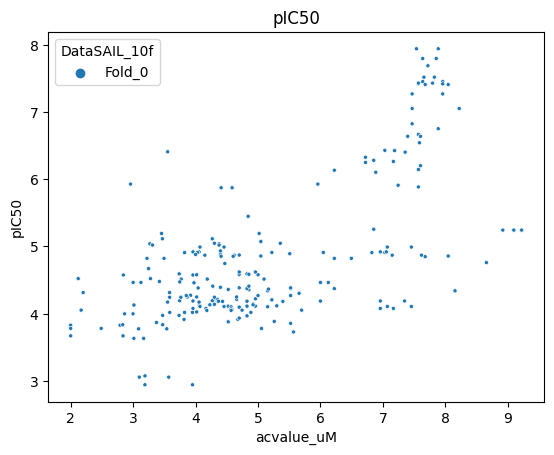

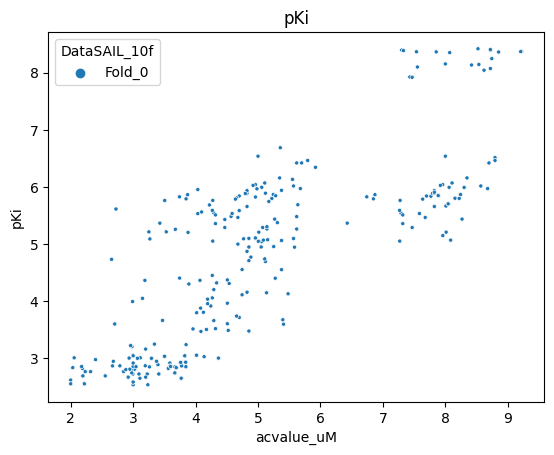

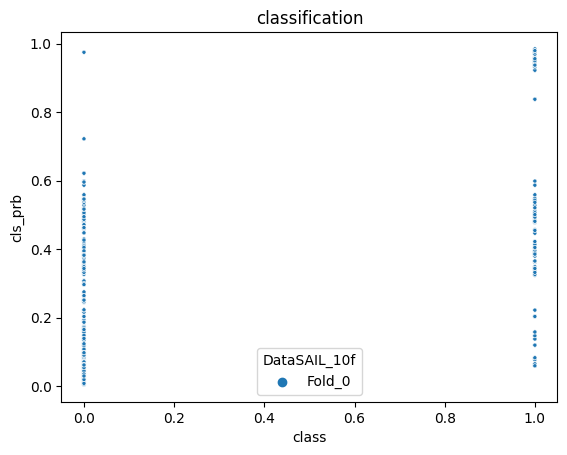

In [26]:


ids = merged_df.DataSAIL_10f == "Fold_0"
for acname in target_names:
    selected_df = merged_df.loc[ids & (merged_df.acname == acname), ["acvalue_uM", acname, "DataSAIL_10f", "ID"]]
    sns.scatterplot(
        data=selected_df, 
        x="acvalue_uM", 
        y=acname, 
        hue="DataSAIL_10f", 
        marker='.'
    )
    ax = plt.gca()
    ax.set_title(acname)
    # plt.gca().set_aspect("equal")
    plt.show()
selected_df = merged_df.loc[ids, ["class", "cls_prb", "DataSAIL_10f", "ID"]]
sns.scatterplot(
    data=selected_df, 
    x="class", 
    y="cls_prb",  
    hue="DataSAIL_10f", 
    marker='.'
)
ax = plt.gca()
ax.set_title("classification")
# plt.gca().set_aspect("equal")
plt.show()

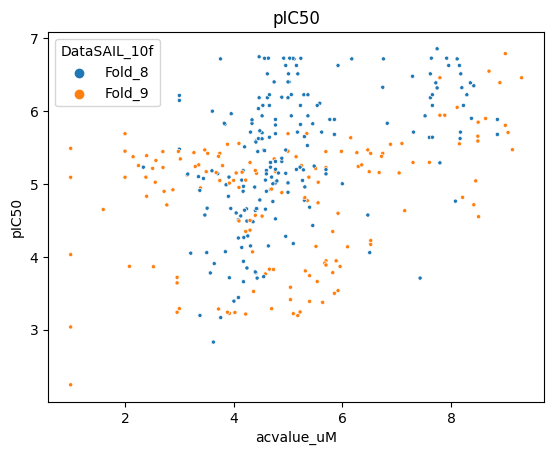

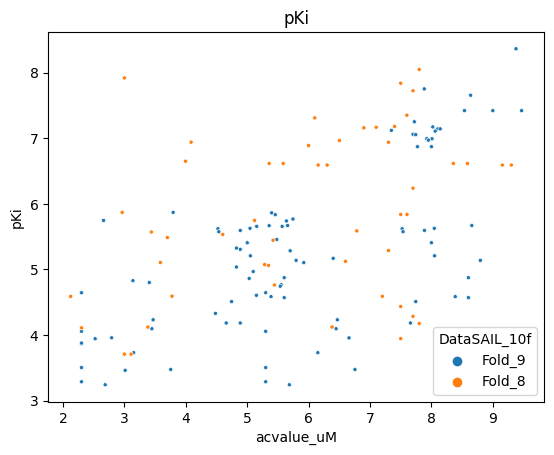

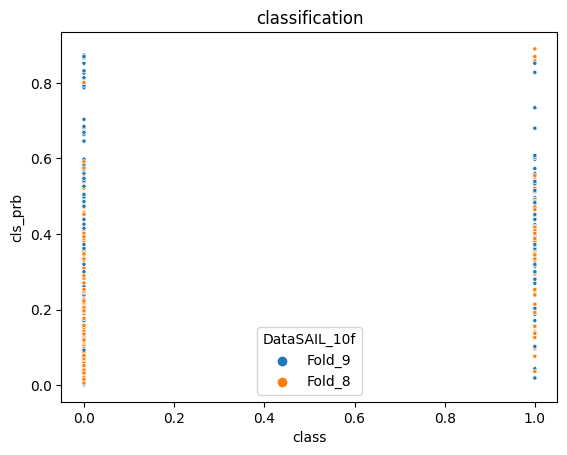

In [27]:
ids = merged_df.DataSAIL_10f.isin(["Fold_8", "Fold_9"])

for acname in target_names:
    selected_df = merged_df.loc[ids & (merged_df.acname == acname), ["acvalue_uM", acname, "DataSAIL_10f", "ID"]]
    sns.scatterplot(
        data=selected_df, 
        x="acvalue_uM", 
        y=acname, 
        hue="DataSAIL_10f", 
        marker='.'
    )
    ax = plt.gca()
    ax.set_title(acname)
    # plt.gca().set_aspect("equal")
    plt.show()
selected_df = merged_df.loc[ids, ["class", "cls_prb", "DataSAIL_10f", "ID"]]
sns.scatterplot(
    data=selected_df, 
    x="class", 
    y="cls_prb",  
    hue="DataSAIL_10f", 
    marker='.'
)
ax = plt.gca()
ax.set_title("classification")
# plt.gca().set_aspect("equal")
plt.show()